# Homework 1.X. - Assessing the OLS Model
## Data Analysis
### FINM August Review 

Mark Hendricks

hendricks@uchicago.edu

# 1 Multivariate Regression

This problem utilizes the data in `../data/multi_asset_etf_data.xlsx`.
* Return data on various asset classes.
* This data comes via ETFs, which we will discuss in the Markets series.

In [2]:
# PACKAGES
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sn
import statsmodels.api as sm
import sklearn.linear_model
import matplotlib.pyplot as plt

# Read the data
rets = pd.DataFrame(pd.read_excel(r'../data/multi_asset_etf_data.xlsx', sheet_name= 'total returns'))

rets.set_index('Date', inplace=True)


## 1.1 Correlation

Calculate and display the correlation matrix of the returns.

Consider displaying it with `seaborn.heatmap`.

Which pair has the highest correlation? And the smallest (most negative)?

<Axes: >

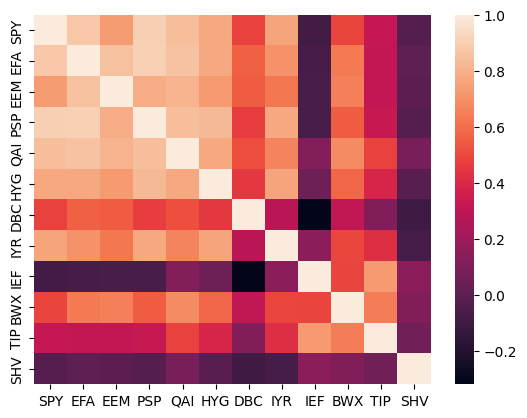

In [3]:
sn.heatmap(rets.corr())

Highest correlation are SPY and PSP and lowest correlation are IEF and DBC.

## 1.2 Multivariate Regression

Suppose that we want to decompose `PSP` into a linear combination of other asset classes.
* `PSP` is a benchmark of private equity returns.
* There is substantial research (and controversy) as to whether private equity returns can be produced from other simple assets.
* We will see.

$$r_t^{\text{PSP}} = \alpha + \boldsymbol{\beta}\boldsymbol{r}_t + \epsilon_t$$

where $\boldsymbol{r}_t$ denotes the vector of all the other returns (excluding PSP) at time $t$.

Report
* the estimated alpha
* the estimated betas
* the r-squared

#### Python tip
Consider forming `X = rets.drop(columns=['PSP'])`.

Consider using one of the following for the regression.
* `statsmodels.OLS`
* `sklearn.linear_models.LinearRegression()`

The former will include various regression statistics. The latter will just produce the estimates.

In [4]:
X = rets.drop(columns=['PSP'])
X_constant = sm.add_constant(X)
y = rets[['PSP']]

ols = sm.OLS(y, X_constant).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                    PSP   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     132.1
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           3.29e-77
Time:                        22:22:00   Log-Likelihood:                 443.72
No. Observations:                 182   AIC:                            -863.4
Df Residuals:                     170   BIC:                            -825.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.794      0.4

## 1.3 Interpretation

Based on your estimates, do you think it is feasible to replicate `PSP` with these other assets? Be specific, citing your answers to the previous question. What does $\alpha$ indicate? What does the r-squared statistic indicate?

### Answer
Yes, it is feasible to replicate PSP with these other assets because the R-squared is almost 0.90. This means that almost 90% of the variation in PSP can be explained by the variation in these indices. 
$\alpha$ represent the return when all other returns are equal to $0$, and it has a negative value, meaning that if we had zero returns on all other assets, the returns on PSP would be negative. 

## 1.4 Multicollinearity

Should we be worried about multicollinearity in this case?

Calculate some metrics about $X'X$, (noting that in our case "$X$" is the array of return data, excluding `PSP`.

* determinant
* conditioning number

What do these metrics indicate?

#### Python tip
You may find these `numpy` functions helpful:
* `numpy.linalg.cond()`
* `numpy.linalg.det()`

In [5]:
print(f"The determinant is {np.linalg.det(X.T@X)} which is greater than zero. The matrix is invertible. But note that it is close to zero. Is must have a strong correlation")

print(f"The conditioning number is {np.linalg.cond(X.T@X)}")

The determinant is 4.732100103650244e-16 which is greater than zero. The matrix is invertible. But note that it is close to zero. Is must have a strong correlation
The conditioning number is 4775.532417793677


## 1.5 Impact of multicollinearity

With multicollinearity, we are concerned that the regression estimates
* are imprecise.
* will change a lot in response to small changes in new data.
* will perform badly out of sample.

To investigate...
* report the t-stats of the betas

## 1.X Extra: 
Estimate the regression, but this time using only data through 2019. 
* Apply these estimated betas to the data in 2020-2022 to construct the replication of `PSP` ($\hat{y}$) out of sample.
* What is the correlation of PSP in 2020-2022 versus this out-of-sample regression estimate?

Graph `PSP` against the regression estimate, both through 2019 (in sample) and 2020-2022 (out of sample.)

In [6]:
X_2019 = rets.loc[(rets.index <= '2019-12-31')].drop(columns=['PSP'])
X_constant_2019 = sm.add_constant(X_2019)
y_2019 = rets.loc[(rets.index <= '2019-12-31')][['PSP']]

ols = sm.OLS(y_2019, X_constant_2019).fit()

betas = ols.params 
# Step 2: Select the data for the 2020-2022 period
X_restricted = rets.loc[(rets.index <= '2022-12-31') & (rets.index >= '2020-01-01')].drop(columns=['PSP'])

# Step 3: Add a constant to the selected data (for the intercept)
X_restricted = sm.add_constant(X_restricted)

# Step 4: Estimate y using the betas
y_estimated_oos = X_restricted.dot(betas)

y_oos = rets.loc[(rets.index <= '2022-12-31') & (rets.index >= '2020-01-01')][['PSP']]

print(f"The correlation of PSP in 2020-2022 vs the out of sample replication of PSP is {y_oos.squeeze().corr(y_estimated_oos)}. Extremely close to 1")


The correlation of PSP in 2020-2022 vs the out of sample replication of PSP is 0.963796503789181. Extremely close to 1


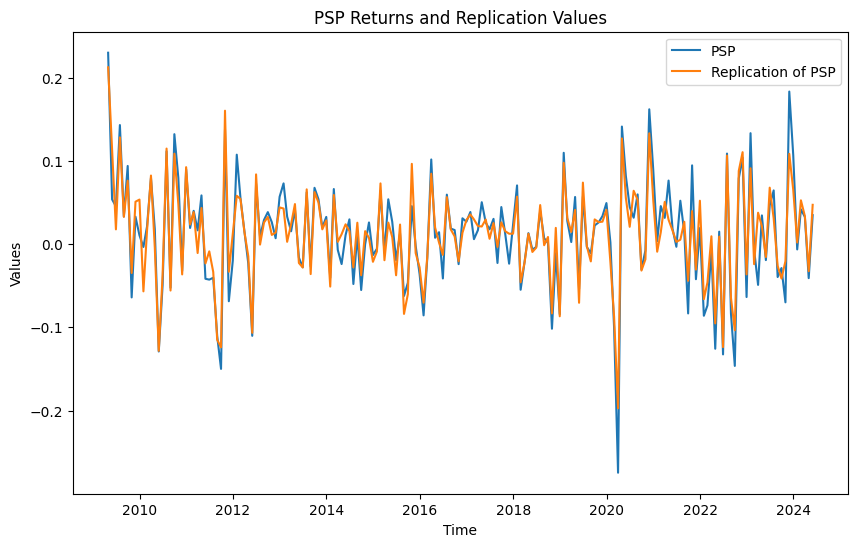

In [7]:
y_estimated = X_constant.dot(betas)

plt.figure(figsize=(10, 6))
plt.plot(y, label='PSP')
plt.plot(y_estimated, label='Replication of PSP')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('PSP Returns and Replication Values')
plt.legend()
plt.show()

# Appendix: Condition number of a matrix

$\newcommand{\olsb}{\boldsymbol{b}}$
$\newcommand{\olsy}{\boldsymbol{y}}$

Consider the linear equation

$$\olsy = a + X\olsb + e$$

Solving for $\olsb$,
$$(X'X)\olsb = X'\olsy$$

Denote the condition number of $X'X$ as $\kappa$.

Then,
$$\frac{||\delta \olsb||}{||\olsb||} \le \kappa \frac{||\delta X'\olsy||}{||X'\olsy||}$$

#### This says that 
- estimation error of size $\delta$ in the covariation of $X$ and $\olsy$ 
- will lead to errors up to size $\kappa\delta$ in the estimation of $\olsb$.

***

# 2 Heteroskedasticity \& Serial Correlation

$$\newcommand{\rspyt}{r_{\text{spy}}}$$
$$\newcommand{\rspyt}{r_{\text{spy},t}}$$

## Data

This problem uses the file, `../data/spy_rates_data.xlsx`.
* Return rates for SPY, the return on the S\&P 500. Denote this as $\rspyt$.
* Dividend-price ratio for the S\&P 500.
* 10-year yields on US Treasuries.

In [8]:
# Read the data
rets_spy = pd.DataFrame(pd.read_excel(r'../data/spy_rate_data.xlsx'))

# Replace the names
rets_spy.columns = ['date', 'SPY', '10y_yield', 'dvd_price_ration']

rets_spy.set_index('date', inplace=True)



## 2.1
Use linear regression to calculate whether S\&P 500 returns (SPY) are impacted by 10-year yields and the dividend-price ratio.

$$\begin{align}
\rspyt = \alpha + \boldsymbol{\beta}'\boldsymbol{X}_t + \epsilon_t
\label{eq:spy_on_macro}
\end{align}$$

where $\boldsymbol{X}$ denotes the matrix of values of the 10-year-yield and the dividend-price ratio.

Report the betas.

## 2.2
Try using `statsmodels.OLS` to estimate the regression, and print the "summary" of the results which will show the t-stats, p-values, etc. Are either of the regressors are statistically significant?

In [9]:
X = rets_spy.drop(columns=['SPY'])
X_constant = sm.add_constant(X)
y = rets_spy[['SPY']]

ols = sm.OLS(y, X_constant).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     4.465
Date:                Fri, 16 Aug 2024   Prob (F-statistic):             0.0125
Time:                        22:22:00   Log-Likelihood:                 423.48
No. Observations:                 239   AIC:                            -841.0
Df Residuals:                     236   BIC:                            -830.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0741      0.023  

### Answer
Yes, the results for both variables are statistically significant both 10-year yield and the dividend ratio. The coefficients (betas) are negative, meaning that both variable have a negative effect on the SPY returns. 

## 2.3
Calculate the correlation between the sample residuals, $e_t$, and their lagged value, $e_{t-1}$. Are they highly correlated? You may find it helpful to use .shift in pandas to get the lagged series.

In [10]:
residuals = ols.resid

lagged_residuals = residuals.shift(1)

residuals.corr(lagged_residuals)

0.050892591625930614

## 2.4
Calculate the regression of
$$e_t = \alpha + \boldsymbol{\beta}'\boldsymbol{X}_t + u_t$$

## 2.5
What do the previous two calculations have to do with identifying serial correlation and heteroskedasticity?

In [11]:
ols_errors = sm.OLS(residuals, X_constant).fit()
print(ols_errors.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                -1.619e-14
Date:                Fri, 16 Aug 2024   Prob (F-statistic):               1.00
Time:                        22:22:00   Log-Likelihood:                 423.48
No. Observations:                 239   AIC:                            -841.0
Df Residuals:                     236   BIC:                            -830.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9.488e-17      0.023  

### Answer
This indicates that there is no serial correlation and the errors are homokedastic.